#### Vanilla RNN 2

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

d = 'cuda'

In [2]:
from data import train_data, test_data

# Optional: view some samples
print("Train:", list(train_data.items())[:2])
print("Test:", list(test_data.items())[:2])


k
Train: [('good', True), ('bad', False)]
Test: [('this is happy', True), ('i am good', True)]


In [3]:
vocab = list(set(w for text in train_data.keys() for w in text.split(' ')))
vocab_size = len(vocab)
print('%d unique words found' % vocab_size)

18 unique words found


In [4]:
wtoi = {w:i for i,w in enumerate(vocab)}
itow = {i:w for i,w in enumerate(vocab)}
itow[7]

'sad'

In [5]:
emb_dim = 10 
C = torch.randn((vocab_size, emb_dim), requires_grad=True, device=d)

x,y = list(train_data.keys()), list(train_data.values())


xenc = [[wtoi[w] for w in text.split(' ')]for text in x]
yenc = [1 if label else 0 for label in y]

xtr = [torch.tensor(seq, dtype=torch.long, device=d) for seq in xenc]
ytr = torch.tensor(yenc, dtype=torch.long, device=d)  




In [6]:
class RNN:

    def __init__(self, input_size, out_put_size, hidden_size):
        # weights
        self.whh = (torch.randn((hidden_size, hidden_size), device=d) / hidden_size**0.5).detach().requires_grad_()
        self.wxh = (torch.randn((input_size, hidden_size), device=d) / input_size**0.5).detach().requires_grad_()
        self.why = (torch.randn((hidden_size, out_put_size), device=d) / hidden_size**0.5).detach().requires_grad_()

        # biases
        self.bh = torch.zeros(hidden_size, requires_grad=True, device=d)
        self.by = torch.zeros(out_put_size, requires_grad=True, device=d)

        # intializing hidden state
        self.h = torch.zeros(1, hidden_size, device=d)

    def __call__(self, x):

        ht_pre = x @ self.wxh + self.h @ self.whh + self.bh
        h_t = torch.tanh(ht_pre)
        
        self.h = h_t

        y_t = h_t @ self.why + self.by
        return y_t
    
    def parameters(self):

        return [self.whh, self.wxh, self.why, self.bh, self.by]
    
    def reset_hidden(self):
        self.h = torch.zeros_like(self.h)




In [7]:
wtoi

{'was': 0,
 'very': 1,
 'right': 2,
 'is': 3,
 'i': 4,
 'or': 5,
 'now': 6,
 'sad': 7,
 'and': 8,
 'this': 9,
 'all': 10,
 'happy': 11,
 'bad': 12,
 'earlier': 13,
 'good': 14,
 'not': 15,
 'am': 16,
 'at': 17}

In [8]:
emb = [C[seq] for seq in xtr]  # Each is (seq_len, emb_dim)
model = RNN(10,2,25)

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
num_epochs = 10000

for epoch in range(num_epochs):
    losses = []
    for x_seq, y_label in zip(xtr, ytr):
        model.reset_hidden()
        for token_idx in x_seq:
            token_emb = C[token_idx].unsqueeze(0)
            logit = model(token_emb)

        loss = F.cross_entropy(logit, y_label.unsqueeze(0))
        losses.append(loss)

    final_loss = torch.stack(losses).mean()
    optimizer.zero_grad()
    final_loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: loss = {final_loss.item():.4f}")


Epoch 0: loss = 0.0008
Epoch 1000: loss = 0.0006
Epoch 2000: loss = 0.0005
Epoch 3000: loss = 0.0004
Epoch 4000: loss = 0.0004
Epoch 5000: loss = 0.0003
Epoch 6000: loss = 0.0003
Epoch 7000: loss = 0.0003
Epoch 8000: loss = 0.0002
Epoch 9000: loss = 0.0002


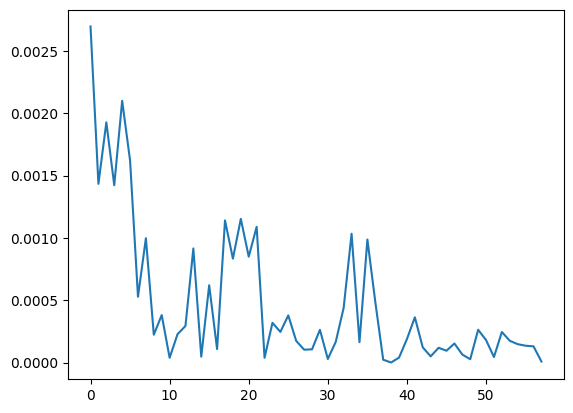

In [238]:
plt.plot([loss.item() for loss in losses])  # Most reliable


In [251]:
sentences = [
    ["i am not happy"],
    ["i am not sad"],
    ["i was bad"]
]

for test in sentences:
    sentence = test[0]
    print("Input:", sentence)

    # Skip unknown words
    test_indices = [wtoi[w] for w in sentence.split() if w in wtoi]
    if not test_indices:
        print("No known words found. Skipping.\n")
        continue

    test_embeddings = [C[idx].unsqueeze(0) for idx in test_indices]

    model.reset_hidden()
    for emb in test_embeddings:
        logits = model(emb)

    probs = torch.softmax(logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()

    print(f"Prediction: {pred} ({'Positive' if pred == 1 else 'Negative'})\n")


Input: i am not happy
Prediction: 0 (Negative)

Input: i am not sad
Prediction: 1 (Positive)

Input: i was bad
Prediction: 0 (Negative)



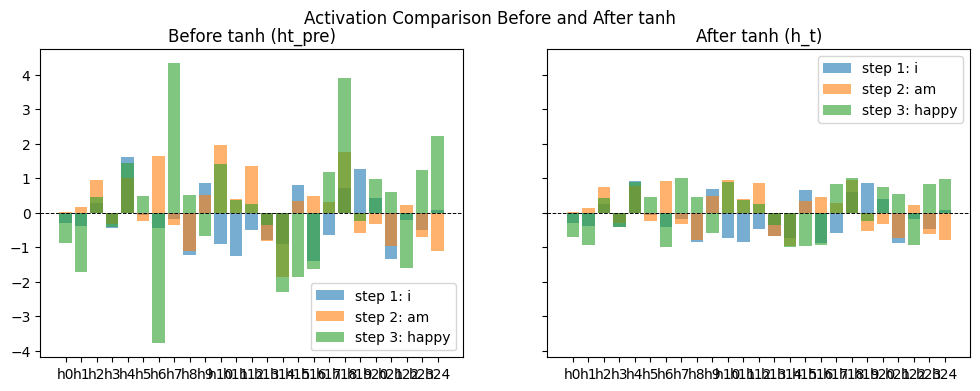

In [253]:
import matplotlib.pyplot as plt

# Choose a test sentence
test_sentence = ["i", "am", "happy"]
test_indices = [wtoi[w] for w in test_sentence]
test_embeddings = [C[idx].unsqueeze(0) for idx in test_indices]

model.reset_hidden()

# Store values
pre_acts = []
post_acts = []

for emb in test_embeddings:
    ht_pre = emb @ model.wxh + model.h @ model.whh + model.bh  # (1, hidden)
    h_t = torch.tanh(ht_pre)

    pre_acts.append(ht_pre.squeeze().detach().cpu())
    post_acts.append(h_t.squeeze().detach().cpu())

    model.h = h_t

# Number of time steps (tokens)
n_steps = len(test_sentence)
hidden_size = pre_acts[0].shape[0]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for i in range(n_steps):
    axes[0].bar(
        [f"h{i}" for i in range(hidden_size)],
        pre_acts[i].numpy(),
        alpha=0.6,
        label=f"step {i+1}: {test_sentence[i]}"
    )

for i in range(n_steps):
    axes[1].bar(
        [f"h{i}" for i in range(hidden_size)],
        post_acts[i].numpy(),
        alpha=0.6,
        label=f"step {i+1}: {test_sentence[i]}"
    )

axes[0].set_title("Before tanh (ht_pre)")
axes[1].set_title("After tanh (h_t)")
axes[0].legend()
axes[1].legend()
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.7)
plt.suptitle("Activation Comparison Before and After tanh")
plt.show()


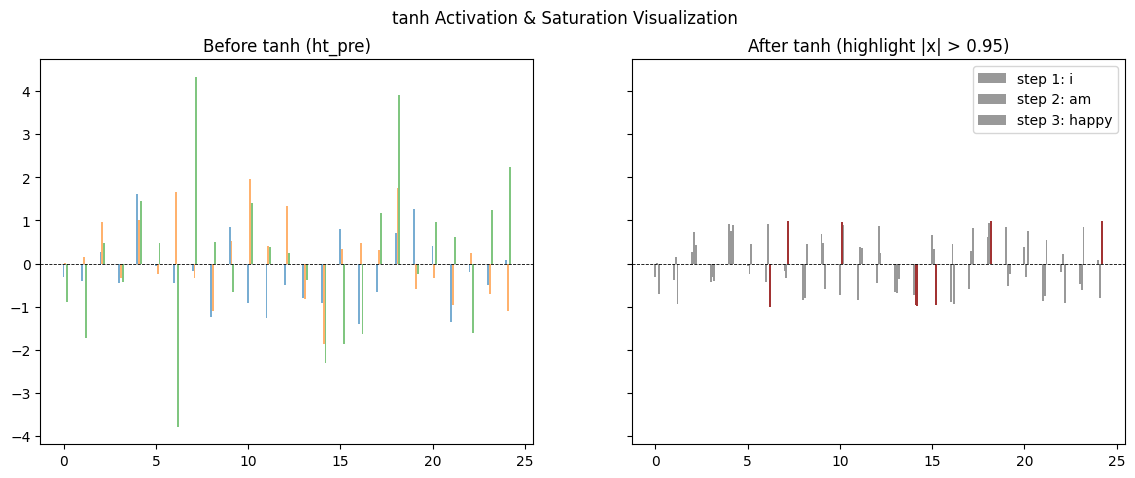

In [ ]:

def visualize_tanh_effect_with_saturation(model, sentence_tokens, threshold=0.95):
    test_indices = [wtoi[w] for w in sentence_tokens]
    test_embeddings = [C[idx].unsqueeze(0) for idx in test_indices]

    model.reset_hidden()

    pre_acts = []
    post_acts = []
    saturation_mask = []

    for emb in test_embeddings:
        ht_pre = emb @ model.wxh + model.h @ model.whh + model.bh  # (1, hidden)
        h_t = torch.tanh(ht_pre)

        pre_acts.append(ht_pre.squeeze().detach().cpu())
        post_acts.append(h_t.squeeze().detach().cpu())
        saturation_mask.append((h_t.abs() > threshold).squeeze().cpu())

        model.h = h_t

    n_steps = len(sentence_tokens)
    hidden_size = pre_acts[0].shape[0]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Before tanh
    for i in range(n_steps):
        axes[0].bar(
            torch.arange(hidden_size) + i*0.1,  # shift to avoid overlap
            pre_acts[i],
            width=0.1,
            label=f"step {i+1}: {sentence_tokens[i]}",
            alpha=0.6
        )

    axes[0].set_title("Before tanh (ht_pre)")
    axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.6)

    # After tanh with saturation highlight
    for i in range(n_steps):
        colors = ['darkred' if is_sat else 'gray' for is_sat in saturation_mask[i]]
        axes[1].bar(
            torch.arange(hidden_size) + i*0.1,
            post_acts[i],
            width=0.1,
            label=f"step {i+1}: {sentence_tokens[i]}",
            color=colors,
            alpha=0.8
        )

    axes[1].set_title(f"After tanh (highlight |x| > {threshold})")
    axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.6)

    plt.suptitle("tanh Activation & Saturation Visualization")
    plt.legend()
    plt.show()

# Example usage:
visualize_tanh_effect_with_saturation(model, ["i", "am", "happy"])
